In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import time
import datetime
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import timm
import segmentation_models_pytorch as smp
import random
from sklearn.model_selection import train_test_split
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
batch_size=2
img_size=1024
class_list=['NT_epithelial','NT_immune','NT_stroma','TP_in_situ','TP_invasive']
tf = ToTensor()
topilimage = torchvision.transforms.ToPILImage()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

2024-08-08 17:20:22.401856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 17:20:23.222741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
img_path='../../data/area_segmentation/BRID/image/'
img_list=glob(img_path+'*.jpeg')
mask_list=[i.replace('/image/','/mask/') for i in img_list]
mask_list=[i.replace('.jpeg','.npy') for i in mask_list]
train_img_list,test_img_list,train_mask_list,test_mask_list=train_test_split(img_list,mask_list,test_size=0.2,random_state=42)

test_image=torch.zeros((len(test_img_list),3,img_size,img_size))
test_mask=torch.zeros((len(test_img_list),len(class_list),img_size,img_size),dtype=torch.float32)    
train_image=torch.zeros((len(train_img_list),3,img_size,img_size))
train_mask=torch.zeros((len(train_img_list),len(class_list),img_size,img_size),dtype=torch.float32)

for i in tqdm(range(len(train_img_list))):
    train_image[i] = tf(Image.open(train_img_list[i]))
    np_mask=np.load(train_mask_list[i])
    for j in range(3):
        train_mask[i,j+1]=tf(np_mask[...,j]/255.)
    train_mask[i,4]=tf(np_mask[...,3]/255.)
    train_mask[i,4]=tf(np_mask[...,4]/255.)
    train_mask[i,0]=1-train_mask[i,1:len(class_list)+1].sum(0)
for i in tqdm(range(len(test_img_list))):
    test_image[i] = tf(Image.open(test_img_list[i]))
    np_mask=np.load(test_mask_list[i])
    for j in range(3):
        test_mask[i,j+1]=tf(np_mask[...,j]/255.)
    test_mask[i,4]=tf(np_mask[...,3]/255.)
    test_mask[i,4]=tf(np_mask[...,4]/255.)
    test_mask[i,0]=1-test_mask[i,1:len(class_list)+1].sum(0)


100%|██████████| 90/90 [00:50<00:00,  1.79it/s]


In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list
        
    def trans(self,image,label):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            label = transform(label)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            label = transform(label)
            image = transform(image)
            
        return image,label
    
    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_path,label_path = self.img_path[idx],self.label[idx]

        return image_path, label_path
    
train_dataset = CustomDataset(train_image, train_mask)

test_dataset = CustomDataset(test_image, test_mask)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
model = smp.UnetPlusPlus(
        encoder_name="efficientnet-b7",
        encoder_weights="imagenet",# use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=len(class_list),                      # model output channels (number of classes in your dataset) 
    ).to(device)
summary(model,(batch_size,3,img_size,img_size))
def dice_loss(pred, target, num_classes=len(class_list)):
    smooth = 1e-6
    dice_per_class = torch.zeros((len(pred),num_classes)).to(pred.device)
    pred=F.softmax(pred,dim=1)
    for i in range(len(pred)):
        for class_id in range(num_classes):
            pred_class = pred[i, class_id, ...]
            target_class = target[i, class_id, ...]
            
            intersection = torch.sum(pred_class * target_class)
            A_sum = torch.sum(pred_class * pred_class)
            B_sum = torch.sum(target_class * target_class)
            dice_per_class[i,class_id] =(2. * intersection + smooth) / (A_sum + B_sum + smooth)

    return 1-dice_per_class.mean()

  0%|          | 0/178 [00:00<?, ?it/s]

epoch: 1/1000 Step: 179 dice_loss : 0.6222 dice_score: 0.3778: 100%|██████████| 178/178 [01:38<00:00,  1.80it/s]
test epoch: 1/1000 Step: 46 dice_loss : 0.5788  dice_score: 0.4212: 100%|██████████| 45/45 [00:06<00:00,  6.54it/s]
epoch: 2/1000 Step: 179 dice_loss : 0.5462 dice_score: 0.4538: 100%|██████████| 178/178 [01:28<00:00,  2.01it/s]
test epoch: 2/1000 Step: 46 dice_loss : 0.5258  dice_score: 0.4742: 100%|██████████| 45/45 [00:06<00:00,  6.45it/s]
epoch: 3/1000 Step: 179 dice_loss : 0.5195 dice_score: 0.4805: 100%|██████████| 178/178 [01:28<00:00,  2.01it/s]
test epoch: 3/1000 Step: 46 dice_loss : 0.5308  dice_score: 0.4692: 100%|██████████| 45/45 [00:06<00:00,  6.58it/s]
epoch: 4/1000 Step: 179 dice_loss : 0.5019 dice_score: 0.4981: 100%|██████████| 178/178 [01:27<00:00,  2.04it/s]
test epoch: 4/1000 Step: 46 dice_loss : 0.5234  dice_score: 0.4766: 100%|██████████| 45/45 [00:06<00:00,  6.53it/s]
epoch: 5/1000 Step: 179 dice_loss : 0.4781 dice_score: 0.5219: 100%|██████████| 178/

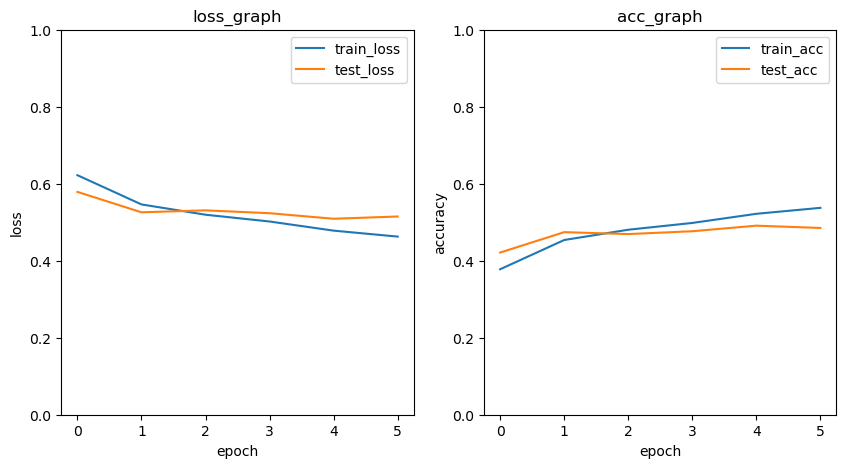

epoch: 7/1000 Step: 179 dice_loss : 0.4455 dice_score: 0.5545: 100%|██████████| 178/178 [01:28<00:00,  2.02it/s]
test epoch: 7/1000 Step: 46 dice_loss : 0.5150  dice_score: 0.4850: 100%|██████████| 45/45 [00:06<00:00,  6.60it/s]
epoch: 8/1000 Step: 179 dice_loss : 0.4316 dice_score: 0.5684: 100%|██████████| 178/178 [01:29<00:00,  1.99it/s]
test epoch: 8/1000 Step: 46 dice_loss : 0.5288  dice_score: 0.4712: 100%|██████████| 45/45 [00:06<00:00,  6.76it/s]
epoch: 9/1000 Step: 179 dice_loss : 0.4177 dice_score: 0.5823: 100%|██████████| 178/178 [01:28<00:00,  2.02it/s]
test epoch: 9/1000 Step: 46 dice_loss : 0.5074  dice_score: 0.4926: 100%|██████████| 45/45 [00:06<00:00,  6.44it/s]
epoch: 10/1000 Step: 179 dice_loss : 0.4094 dice_score: 0.5906: 100%|██████████| 178/178 [01:28<00:00,  2.02it/s]
test epoch: 10/1000 Step: 46 dice_loss : 0.5152  dice_score: 0.4848: 100%|██████████| 45/45 [00:06<00:00,  6.65it/s]
epoch: 11/1000 Step: 179 dice_loss : 0.3996 dice_score: 0.6004: 100%|██████████| 1

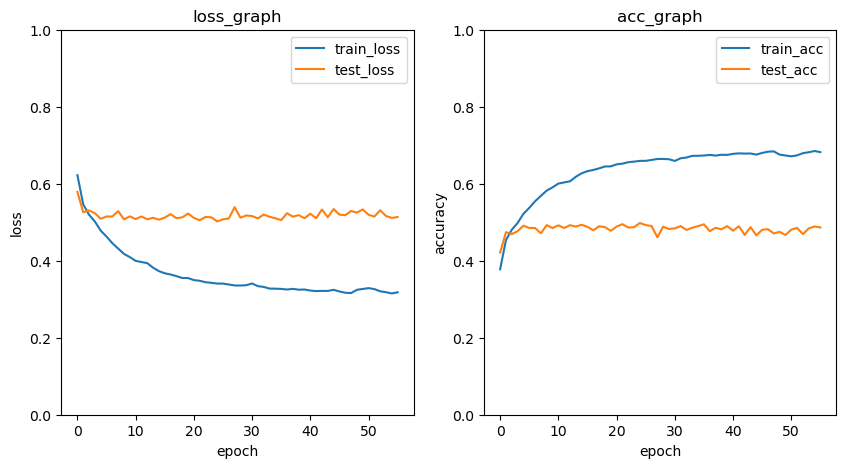

epoch: 57/1000 Step: 179 dice_loss : 0.3143 dice_score: 0.6857: 100%|██████████| 178/178 [01:28<00:00,  2.01it/s]
test epoch: 57/1000 Step: 46 dice_loss : 0.5185  dice_score: 0.4815: 100%|██████████| 45/45 [00:06<00:00,  6.67it/s]
epoch: 58/1000 Step: 179 dice_loss : 0.3131 dice_score: 0.6869: 100%|██████████| 178/178 [01:30<00:00,  1.98it/s]
test epoch: 58/1000 Step: 46 dice_loss : 0.5179  dice_score: 0.4821: 100%|██████████| 45/45 [00:06<00:00,  6.63it/s]
epoch: 59/1000 Step: 179 dice_loss : 0.3111 dice_score: 0.6889: 100%|██████████| 178/178 [01:28<00:00,  2.01it/s]
test epoch: 59/1000 Step: 46 dice_loss : 0.5213  dice_score: 0.4787: 100%|██████████| 45/45 [00:06<00:00,  6.69it/s]
epoch: 60/1000 Step: 179 dice_loss : 0.3108 dice_score: 0.6892: 100%|██████████| 178/178 [01:28<00:00,  2.01it/s]
test epoch: 60/1000 Step: 46 dice_loss : 0.5142  dice_score: 0.4858: 100%|██████████| 45/45 [00:07<00:00,  6.41it/s]
epoch: 61/1000 Step: 179 dice_loss : 0.3106 dice_score: 0.6894: 100%|███████

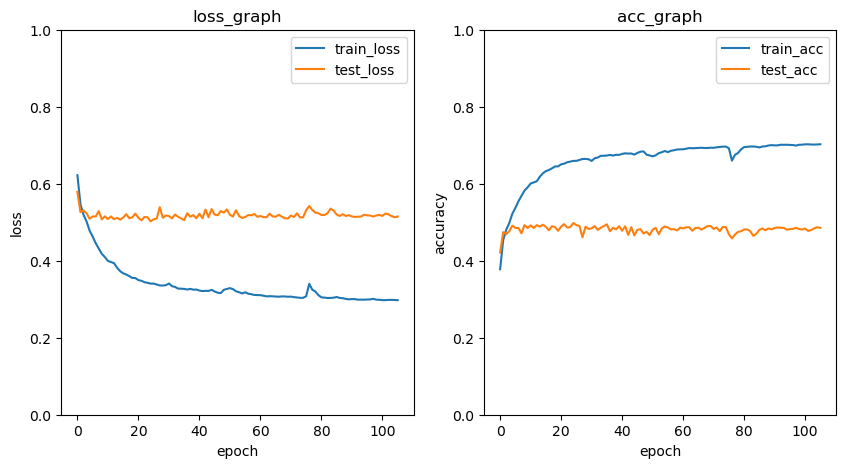

epoch: 107/1000 Step: 179 dice_loss : 0.2966 dice_score: 0.7034: 100%|██████████| 178/178 [01:31<00:00,  1.95it/s]
test epoch: 107/1000 Step: 46 dice_loss : 0.5146  dice_score: 0.4854: 100%|██████████| 45/45 [00:06<00:00,  6.64it/s]
epoch: 108/1000 Step: 179 dice_loss : 0.2967 dice_score: 0.7033: 100%|██████████| 178/178 [01:40<00:00,  1.77it/s]
test epoch: 108/1000 Step: 46 dice_loss : 0.5172  dice_score: 0.4828: 100%|██████████| 45/45 [00:09<00:00,  4.82it/s]
epoch: 109/1000 Step: 179 dice_loss : 0.2977 dice_score: 0.7023: 100%|██████████| 178/178 [01:30<00:00,  1.98it/s]
test epoch: 109/1000 Step: 46 dice_loss : 0.5280  dice_score: 0.4720: 100%|██████████| 45/45 [00:06<00:00,  6.70it/s]
epoch: 110/1000 Step: 179 dice_loss : 0.3137 dice_score: 0.6863: 100%|██████████| 178/178 [01:29<00:00,  1.99it/s]
test epoch: 110/1000 Step: 46 dice_loss : 0.5500  dice_score: 0.4500: 100%|██████████| 45/45 [00:06<00:00,  6.56it/s]
epoch: 111/1000 Step: 179 dice_loss : 0.3170 dice_score: 0.6830: 100

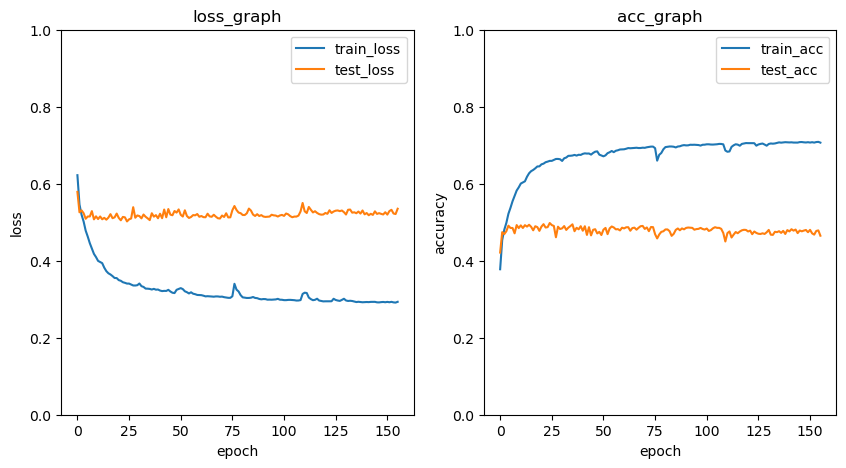

epoch: 157/1000 Step: 179 dice_loss : 0.2979 dice_score: 0.7021: 100%|██████████| 178/178 [01:47<00:00,  1.65it/s]
test epoch: 157/1000 Step: 46 dice_loss : 0.6250  dice_score: 0.3750: 100%|██████████| 45/45 [00:08<00:00,  5.03it/s]
epoch: 158/1000 Step: 179 dice_loss : 0.3188 dice_score: 0.6812: 100%|██████████| 178/178 [01:47<00:00,  1.66it/s]
test epoch: 158/1000 Step: 46 dice_loss : 0.5335  dice_score: 0.4665: 100%|██████████| 45/45 [00:08<00:00,  5.15it/s]
epoch: 159/1000 Step: 179 dice_loss : 0.3067 dice_score: 0.6933: 100%|██████████| 178/178 [01:51<00:00,  1.60it/s]
test epoch: 159/1000 Step: 46 dice_loss : 0.5202  dice_score: 0.4798: 100%|██████████| 45/45 [00:08<00:00,  5.09it/s]
epoch: 160/1000 Step: 179 dice_loss : 0.2962 dice_score: 0.7038: 100%|██████████| 178/178 [01:48<00:00,  1.64it/s]
test epoch: 160/1000 Step: 46 dice_loss : 0.5179  dice_score: 0.4821: 100%|██████████| 45/45 [00:08<00:00,  5.05it/s]
epoch: 161/1000 Step: 179 dice_loss : 0.2926 dice_score: 0.7074: 100

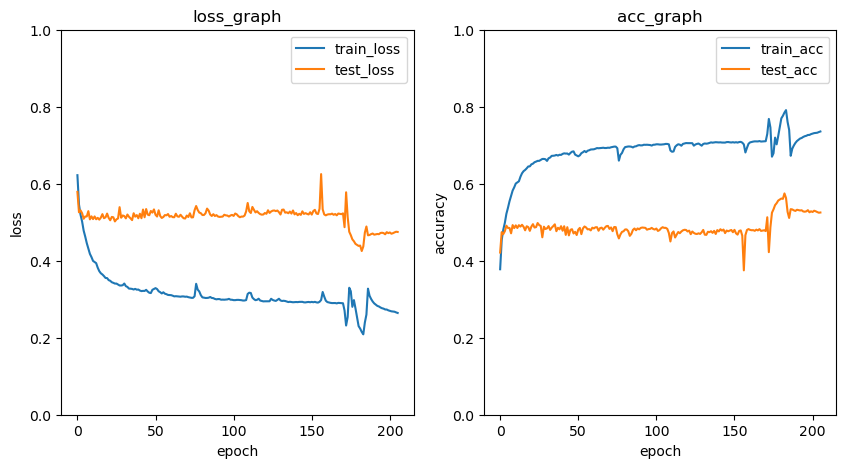

epoch: 207/1000 Step: 179 dice_loss : 0.2634 dice_score: 0.7366: 100%|██████████| 178/178 [01:27<00:00,  2.03it/s]
test epoch: 207/1000 Step: 46 dice_loss : 0.4755  dice_score: 0.5245: 100%|██████████| 45/45 [00:06<00:00,  6.72it/s]
epoch: 208/1000 Step: 179 dice_loss : 0.2633 dice_score: 0.7367: 100%|██████████| 178/178 [01:26<00:00,  2.07it/s]
test epoch: 208/1000 Step: 46 dice_loss : 0.4743  dice_score: 0.5257: 100%|██████████| 45/45 [00:06<00:00,  6.72it/s]
epoch: 209/1000 Step: 179 dice_loss : 0.2631 dice_score: 0.7369: 100%|██████████| 178/178 [01:26<00:00,  2.06it/s]
test epoch: 209/1000 Step: 46 dice_loss : 0.4744  dice_score: 0.5256: 100%|██████████| 45/45 [00:06<00:00,  6.67it/s]
epoch: 210/1000 Step: 179 dice_loss : 0.2620 dice_score: 0.7380: 100%|██████████| 178/178 [01:27<00:00,  2.04it/s]
test epoch: 210/1000 Step: 46 dice_loss : 0.4790  dice_score: 0.5210: 100%|██████████| 45/45 [00:06<00:00,  6.74it/s]
epoch: 211/1000 Step: 179 dice_loss : 0.2621 dice_score: 0.7379: 100

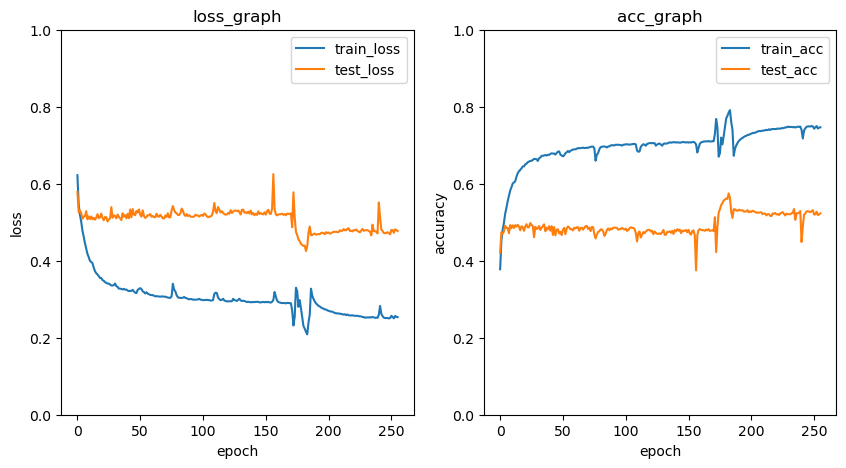

epoch: 257/1000 Step: 179 dice_loss : 0.2523 dice_score: 0.7477: 100%|██████████| 178/178 [01:26<00:00,  2.05it/s]
test epoch: 257/1000 Step: 46 dice_loss : 0.4815  dice_score: 0.5185: 100%|██████████| 45/45 [00:06<00:00,  6.80it/s]
epoch: 258/1000 Step: 179 dice_loss : 0.2494 dice_score: 0.7506: 100%|██████████| 178/178 [01:40<00:00,  1.78it/s]
test epoch: 258/1000 Step: 46 dice_loss : 0.4769  dice_score: 0.5231: 100%|██████████| 45/45 [00:06<00:00,  6.76it/s]
epoch: 259/1000 Step: 179 dice_loss : 0.2508 dice_score: 0.7492: 100%|██████████| 178/178 [01:29<00:00,  1.99it/s]
test epoch: 259/1000 Step: 46 dice_loss : 0.4802  dice_score: 0.5198: 100%|██████████| 45/45 [00:11<00:00,  3.95it/s]
epoch: 260/1000 Step: 179 dice_loss : 0.2506 dice_score: 0.7494: 100%|██████████| 178/178 [01:49<00:00,  1.62it/s]
test epoch: 260/1000 Step: 46 dice_loss : 0.4789  dice_score: 0.5211: 100%|██████████| 45/45 [00:06<00:00,  6.69it/s]
epoch: 261/1000 Step: 179 dice_loss : 0.2503 dice_score: 0.7497: 100

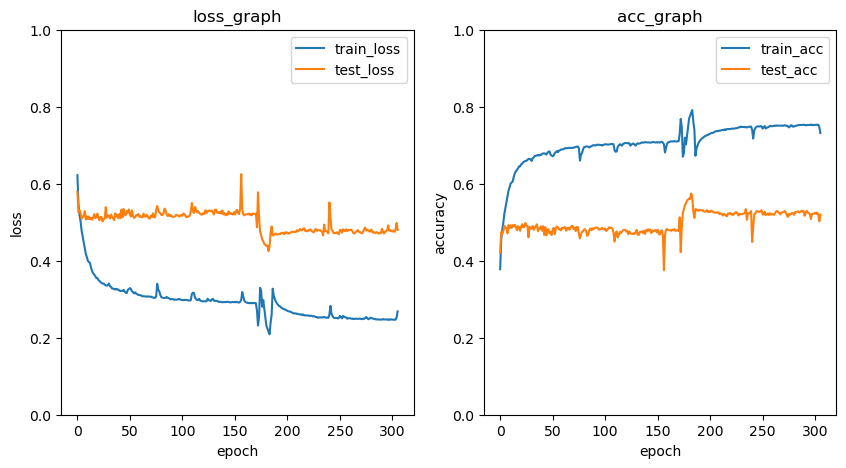

epoch: 307/1000 Step: 179 dice_loss : 0.2586 dice_score: 0.7414: 100%|██████████| 178/178 [01:57<00:00,  1.52it/s]
test epoch: 307/1000 Step: 46 dice_loss : 0.4779  dice_score: 0.5221: 100%|██████████| 45/45 [00:11<00:00,  3.77it/s]
epoch: 308/1000 Step: 179 dice_loss : 0.2550 dice_score: 0.7450: 100%|██████████| 178/178 [01:58<00:00,  1.50it/s]
test epoch: 308/1000 Step: 46 dice_loss : 0.4778  dice_score: 0.5222: 100%|██████████| 45/45 [00:11<00:00,  3.76it/s]
epoch: 309/1000 Step: 179 dice_loss : 0.2515 dice_score: 0.7485: 100%|██████████| 178/178 [01:58<00:00,  1.50it/s]
test epoch: 309/1000 Step: 46 dice_loss : 0.4743  dice_score: 0.5257: 100%|██████████| 45/45 [00:12<00:00,  3.73it/s]
epoch: 310/1000 Step: 179 dice_loss : 0.2477 dice_score: 0.7523: 100%|██████████| 178/178 [01:57<00:00,  1.52it/s]
test epoch: 310/1000 Step: 46 dice_loss : 0.4822  dice_score: 0.5178: 100%|██████████| 45/45 [00:12<00:00,  3.48it/s]
epoch: 311/1000 Step: 179 dice_loss : 0.2481 dice_score: 0.7519: 100

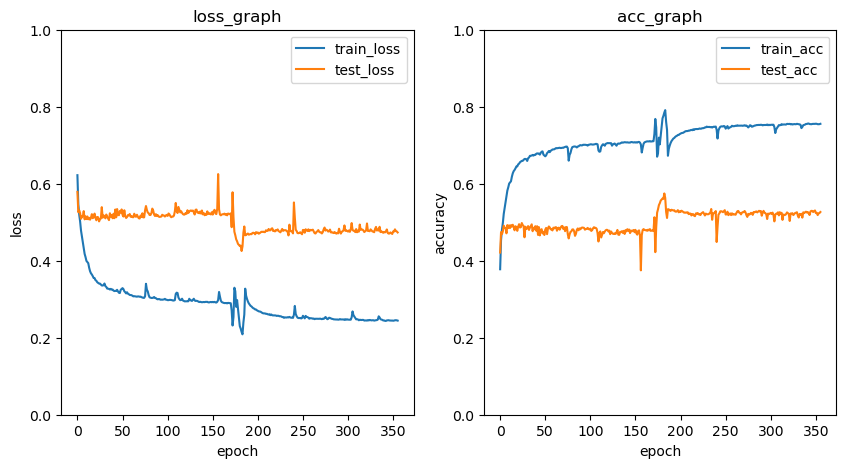

epoch: 357/1000 Step: 179 dice_loss : 0.2453 dice_score: 0.7547: 100%|██████████| 178/178 [01:26<00:00,  2.05it/s]
test epoch: 357/1000 Step: 46 dice_loss : 0.4737  dice_score: 0.5263: 100%|██████████| 45/45 [00:06<00:00,  6.91it/s]
epoch: 358/1000 Step: 179 dice_loss : 0.2448 dice_score: 0.7552: 100%|██████████| 178/178 [01:27<00:00,  2.04it/s]
test epoch: 358/1000 Step: 46 dice_loss : 0.4780  dice_score: 0.5220: 100%|██████████| 45/45 [00:06<00:00,  6.75it/s]
epoch: 359/1000 Step: 179 dice_loss : 0.2442 dice_score: 0.7558: 100%|██████████| 178/178 [01:25<00:00,  2.07it/s]
test epoch: 359/1000 Step: 46 dice_loss : 0.4717  dice_score: 0.5283: 100%|██████████| 45/45 [00:06<00:00,  6.78it/s]
epoch: 360/1000 Step: 179 dice_loss : 0.2445 dice_score: 0.7555: 100%|██████████| 178/178 [01:27<00:00,  2.05it/s]
test epoch: 360/1000 Step: 46 dice_loss : 0.4731  dice_score: 0.5269: 100%|██████████| 45/45 [00:06<00:00,  6.71it/s]
epoch: 361/1000 Step: 179 dice_loss : 0.2446 dice_score: 0.7554: 100

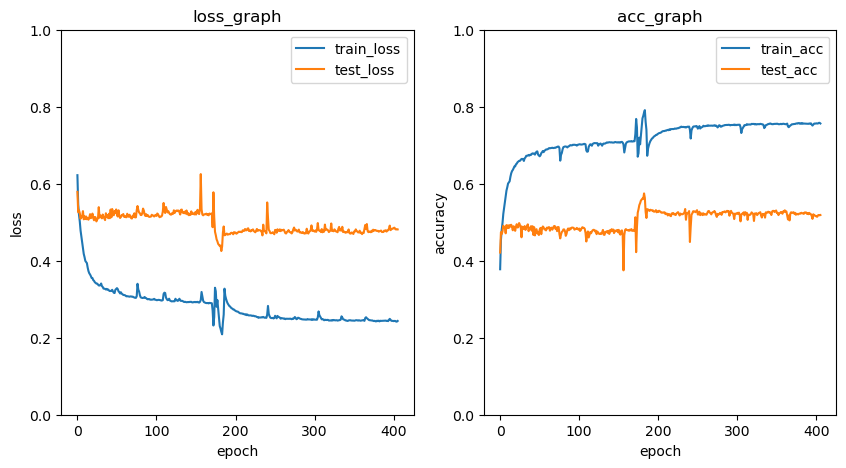

epoch: 407/1000 Step: 179 dice_loss : 0.2438 dice_score: 0.7562: 100%|██████████| 178/178 [01:26<00:00,  2.06it/s]
test epoch: 407/1000 Step: 46 dice_loss : 0.4843  dice_score: 0.5157: 100%|██████████| 45/45 [00:06<00:00,  6.77it/s]
epoch: 408/1000 Step: 179 dice_loss : 0.2437 dice_score: 0.7563: 100%|██████████| 178/178 [01:26<00:00,  2.07it/s]
test epoch: 408/1000 Step: 46 dice_loss : 0.4854  dice_score: 0.5146: 100%|██████████| 45/45 [00:06<00:00,  6.83it/s]
epoch: 409/1000 Step: 179 dice_loss : 0.2431 dice_score: 0.7569: 100%|██████████| 178/178 [01:26<00:00,  2.07it/s]
test epoch: 409/1000 Step: 46 dice_loss : 0.4847  dice_score: 0.5153: 100%|██████████| 45/45 [00:06<00:00,  6.72it/s]
epoch: 410/1000 Step: 179 dice_loss : 0.2437 dice_score: 0.7563: 100%|██████████| 178/178 [01:25<00:00,  2.07it/s]
test epoch: 410/1000 Step: 46 dice_loss : 0.4819  dice_score: 0.5181: 100%|██████████| 45/45 [00:06<00:00,  6.78it/s]
epoch: 411/1000 Step: 179 dice_loss : 0.2437 dice_score: 0.7563: 100

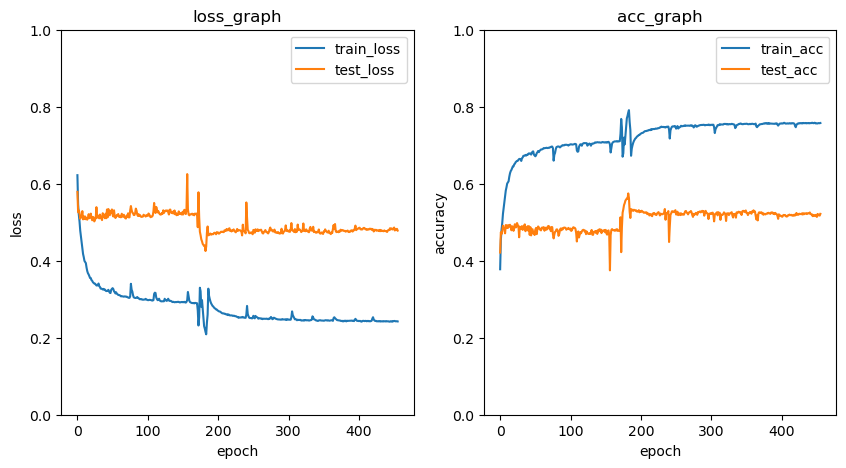

epoch: 457/1000 Step: 179 dice_loss : 0.2420 dice_score: 0.7580: 100%|██████████| 178/178 [01:26<00:00,  2.06it/s]
test epoch: 457/1000 Step: 46 dice_loss : 0.4780  dice_score: 0.5220: 100%|██████████| 45/45 [00:06<00:00,  6.80it/s]
epoch: 458/1000 Step: 179 dice_loss : 0.2427 dice_score: 0.7573: 100%|██████████| 178/178 [01:26<00:00,  2.07it/s]
test epoch: 458/1000 Step: 46 dice_loss : 0.4830  dice_score: 0.5170: 100%|██████████| 45/45 [00:06<00:00,  6.83it/s]
epoch: 459/1000 Step: 179 dice_loss : 0.2417 dice_score: 0.7583: 100%|██████████| 178/178 [01:26<00:00,  2.06it/s]
test epoch: 459/1000 Step: 46 dice_loss : 0.4753  dice_score: 0.5247: 100%|██████████| 45/45 [00:06<00:00,  6.91it/s]
epoch: 460/1000 Step: 179 dice_loss : 0.2415 dice_score: 0.7585: 100%|██████████| 178/178 [01:26<00:00,  2.06it/s]
test epoch: 460/1000 Step: 46 dice_loss : 0.4762  dice_score: 0.5238: 100%|██████████| 45/45 [00:06<00:00,  6.73it/s]
epoch: 461/1000 Step: 179 dice_loss : 0.2426 dice_score: 0.7574: 100

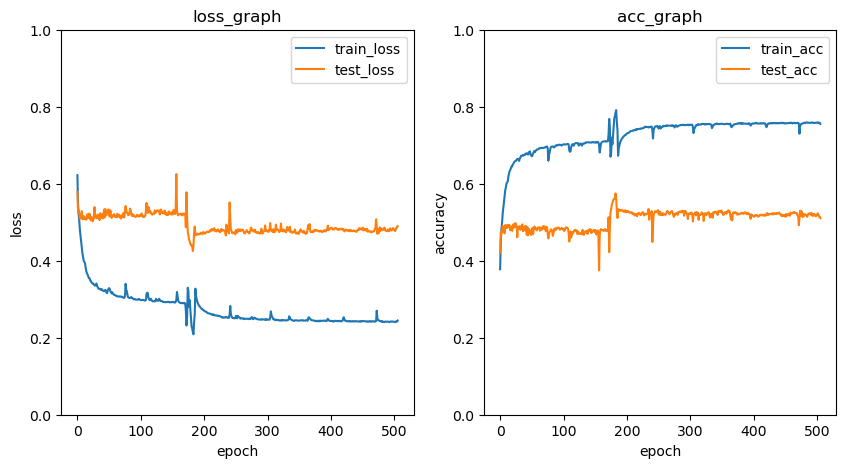

epoch: 507/1000 Step: 179 dice_loss : 0.2473 dice_score: 0.7527: 100%|██████████| 178/178 [01:25<00:00,  2.07it/s]
test epoch: 507/1000 Step: 46 dice_loss : 0.5088  dice_score: 0.4912: 100%|██████████| 45/45 [00:06<00:00,  6.79it/s]
epoch: 508/1000 Step: 179 dice_loss : 0.2481 dice_score: 0.7519: 100%|██████████| 178/178 [01:26<00:00,  2.06it/s]
test epoch: 508/1000 Step: 46 dice_loss : 0.4956  dice_score: 0.5044: 100%|██████████| 45/45 [00:06<00:00,  6.77it/s]
epoch: 509/1000 Step: 179 dice_loss : 0.2490 dice_score: 0.7510: 100%|██████████| 178/178 [01:26<00:00,  2.07it/s]
test epoch: 509/1000 Step: 46 dice_loss : 0.4948  dice_score: 0.5052: 100%|██████████| 45/45 [00:06<00:00,  6.77it/s]
epoch: 510/1000 Step: 179 dice_loss : 0.2447 dice_score: 0.7553: 100%|██████████| 178/178 [01:26<00:00,  2.06it/s]
test epoch: 510/1000 Step: 46 dice_loss : 0.4847  dice_score: 0.5153: 100%|██████████| 45/45 [00:06<00:00,  6.74it/s]
epoch: 511/1000 Step: 179 dice_loss : 0.2425 dice_score: 0.7575: 100

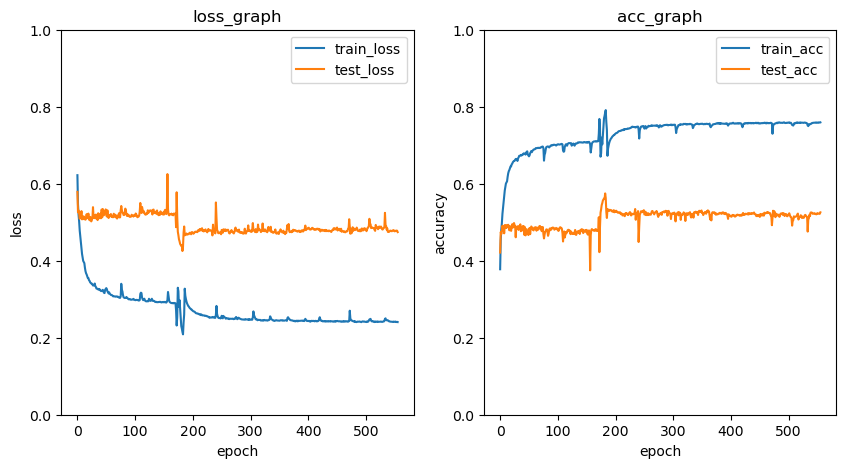

epoch: 557/1000 Step: 179 dice_loss : 0.2413 dice_score: 0.7587: 100%|██████████| 178/178 [01:25<00:00,  2.07it/s]
test epoch: 557/1000 Step: 46 dice_loss : 0.4771  dice_score: 0.5229: 100%|██████████| 45/45 [00:06<00:00,  6.80it/s]
epoch: 558/1000 Step: 179 dice_loss : 0.2401 dice_score: 0.7599: 100%|██████████| 178/178 [01:25<00:00,  2.07it/s]
test epoch: 558/1000 Step: 46 dice_loss : 0.4765  dice_score: 0.5235: 100%|██████████| 45/45 [00:06<00:00,  6.76it/s]
epoch: 559/1000 Step: 179 dice_loss : 0.2419 dice_score: 0.7581: 100%|██████████| 178/178 [01:26<00:00,  2.07it/s]
test epoch: 559/1000 Step: 46 dice_loss : 0.4786  dice_score: 0.5214: 100%|██████████| 45/45 [00:06<00:00,  6.75it/s]
epoch: 560/1000 Step: 179 dice_loss : 0.2419 dice_score: 0.7581: 100%|██████████| 178/178 [01:26<00:00,  2.07it/s]
test epoch: 560/1000 Step: 46 dice_loss : 0.4801  dice_score: 0.5199: 100%|██████████| 45/45 [00:06<00:00,  6.80it/s]
epoch: 561/1000 Step: 179 dice_loss : 0.2416 dice_score: 0.7584: 100

KeyboardInterrupt: 

In [5]:
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
metrics = defaultdict(float)
for epoch in range(1000):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train:
        model.train()
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = dice_loss(predict, y) # cost 구함
        acc=1-cost.item()
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        y = y.to('cpu')

        x=x.to('cpu')
        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {running_loss/count:.4f} dice_score: {1-running_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count))
#test
    val=tqdm(test_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            
            predict = model(x).to(device)
            cost = dice_loss(predict, y) # cost 구함
            acc=1-cost.item()
            val_running_loss+=cost.item()
            acc_loss+=acc
            y = y.to('cpu')
            x=x.to('cpu')
            val.set_description(f"test epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {val_running_loss/count:.4f}  dice_score: {1-val_running_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count))
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/areaSeg/BR_callback.pt')
        MIN_loss=(val_running_loss/count)
        
    if epoch%50==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='test_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='test_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
plt.plot(np.arange(epoch+1),val_acc_list,label='test_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()
print('batch size= 2')
print('image size= 1024,1024')
print('learning rate= 2e-4')